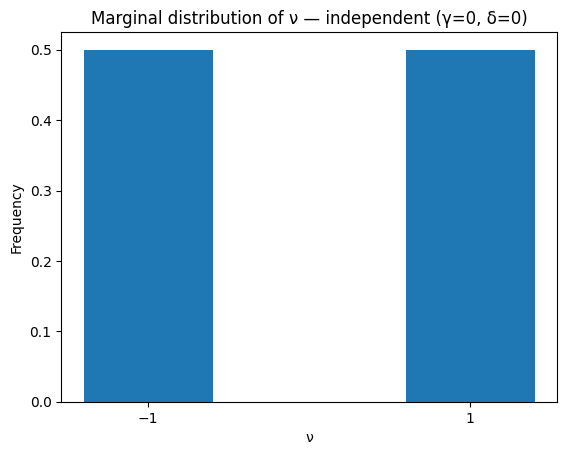

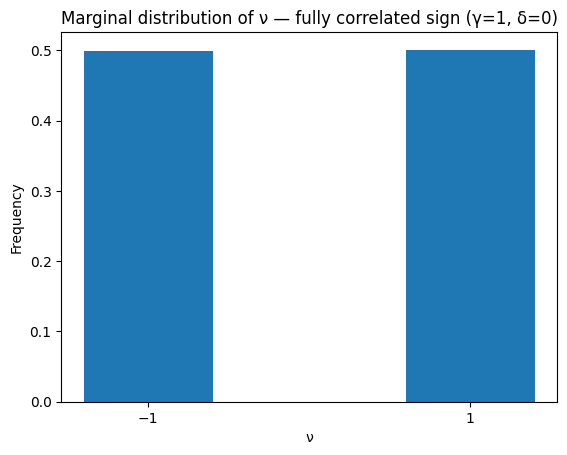

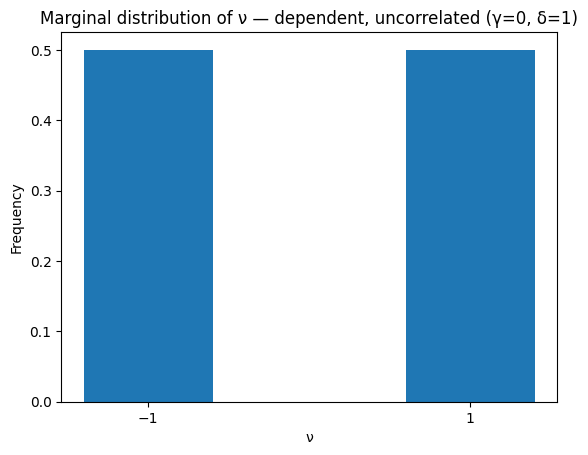

,Case,γ,δ,P(ν=-1),P(ν=+1),E[λν] (empirical),E[λν] (theoretical),abs. error
0,"independent (γ=0, δ=0)",0,0,0.500066,0.499934,-0.003036,0.000000,0.003036
1,"fully correlated sign (γ=1, δ=0)",1,0,0.498966,0.501034,0.798382,0.797885,0.000498
2,"dependent, uncorrelated (γ=0, δ=1)",0,1,0.499638,0.500362,0.000455,0.000000,0.000455


In [16]:
# --- Imports ---
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd

import sys
import os

# Add parent folder (one level up from notebook) to Python path
sys.path.append(os.path.abspath(".."))

# If your function lives in another file, import it here:
from state_evolution import generate_latents, modelF, f_out, Z_out, beta_tilde, int_1, gamma_matrix
# (Otherwise, make sure it's already defined in the notebook.)

# --- Parameters ---
n = 500_000
rng = np.random.default_rng(42)

configs = [
    (0, 0, "independent (γ=0, δ=0)"),
    (1, 0, "fully correlated sign (γ=1, δ=0)"),
    (0, 1, "dependent, uncorrelated (γ=0, δ=1)"),
]

# --- Run tests ---
results = []
for gamma, delta, label in configs:
    lam, nu = generate_latents(n, gamma=gamma, delta=delta)

    e_lam_nu = np.mean(lam * nu)
    p_neg = np.mean(nu == -1)
    p_pos = np.mean(nu == 1)
    theor = gamma * math.sqrt(2 / math.pi)

    results.append({
        "Case": label,
        "γ": gamma,
        "δ": delta,
        "P(ν=-1)": p_neg,
        "P(ν=+1)": p_pos,
        "E[λν] (empirical)": e_lam_nu,
        "E[λν] (theoretical)": theor,
        "abs. error": abs(e_lam_nu - theor)
    })

    # Plot marginal of ν
    plt.figure()
    plt.hist(nu, bins=[-1.5, -0.5, 0.5, 1.5], rwidth=0.8, density=True)
    plt.title(f"Marginal distribution of ν — {label}")
    plt.xlabel("ν")
    plt.ylabel("Frequency")
    plt.xticks([-1, 1])
    plt.show()

# --- Display table ---
results_df = pd.DataFrame(results)
display(results_df.round(6))


In [2]:
import numpy as np

def test_modelF_shape():
    # Example parameters
    beta = (1.0, 2.0)
    h_star = np.array([0.3, -0.7])
    lambda_star = 0.5
    nu_star = -1.0
    beta_tilde_v = 0.8

    # Check both cases of y
    for y in [1, -1]:
        out = modelF(beta, h_star, lambda_star, nu_star, y, beta_tilde_v)
        print(f"y = {y} → output:", out)
        if not isinstance(out, np.ndarray):
            raise AssertionError(f"Output is not a numpy array for y={y}")
        if out.shape != (2,):
            raise AssertionError(f"Wrong shape {out.shape} for y={y}, expected (2,)")
    print("✅ test passed: modelF returns a (2,) vector for both y=±1")

# Run the test
test_modelF_shape()


y = 1 → output: [ 0.5        -0.25649658]
y = -1 → output: [0. 0.]
✅ test passed: modelF returns a (2,) vector for both y=±1


In [5]:
import itertools

In [12]:
def p_out(beta_u, beta_v, gamma, delta, y, z):
    if y == -1:
        return 1/2
    elif y == 1:
        return 1/2*np.sqrt(1+beta_v)*np.exp(-1/2*beta_v*(1+z[1]**2))*int_1(a=beta_u, b=np.sqrt(beta_u)*z[0], c=np.sqrt(beta_v*(1+beta_v))*z[1], d=0, gamma=gamma, delta=delta)

In [15]:
# testing p_out
def p_out_mc_latents(beta_u, beta_v, gamma, delta, y, z, latent_samples=200_000, rng=None):
    if y == -1:
        return 0.5
    if rng is None:
        rng = np.random.default_rng(0)
    lam, nu = generate_latents(latent_samples, gamma=gamma, delta=delta)
    expo = (-0.5*beta_v
            + np.sqrt(beta_u)*lam*z[0]
            + np.sqrt(beta_v*(1+beta_v))*nu*z[1]
            - 0.5*beta_v*(z[1]**2)
            - 0.5*beta_u*(lam**2))
    # NOTE: This matches exactly your int_1 parametrization when d=0 and a=beta_u
    return 0.5 * np.sqrt(1 + beta_v) * np.mean(np.exp(expo))

# ---- Quick check on a few z's ----
beta_u, beta_v = 1.0, 2.0
gamma, delta = 0.0, 0.0
Zs_to_test = [np.array([0.0, 0.0]),
              np.array([0.5, -0.25]),
              np.array([-1.0, 0.8])]

for z in Zs_to_test:
    closed = p_out(beta_u, beta_v, gamma, delta, y=1, z=z)
    mc_est = p_out_mc_latents(beta_u, beta_v, gamma, delta, y=1, z=z, latent_samples=300_000)
    print(f"z={z} | p_out closed={closed:.6f} | MC={mc_est:.6f} | abs err={abs(closed-mc_est):.3e}")

z=[0. 0.] | p_out closed=0.225279 | MC=0.225316 | abs err=3.629e-05
z=[ 0.5  -0.25] | p_out closed=0.268856 | MC=0.269087 | abs err=2.309e-04
z=[-1.   0.8] | p_out closed=0.551945 | MC=0.552347 | abs err=4.020e-04


In [24]:
# testing z_out
# MC Z_out from definition
def Z_out_mc(beta_u, beta_v, gamma, delta, y, omega, V, nZ=50_000, rng=None):
    if rng is None:
        rng = np.random.default_rng(1)
    Z = rng.multivariate_normal(mean=omega, cov=V, size=nZ)
    vals = np.array([p_out(beta_u, beta_v, gamma, delta, y, z) for z in Z])
    return vals.mean()

# Compare on a few (omega, V) pairs; start with V=I for clean mapping (M=I, N=I)
omegas = [np.array([0.0, 0.0]), np.array([0.4, -0.2]), np.array([-1.2, 0.7])]
Vs = [np.array([[0.6, -0.3], [-0.3, 0.5]])]

beta_u, beta_v = 1.0, 2.0
gamma, delta = 0.0, 1.0

beta_tilde_v = beta_tilde(beta_v)
gamma_mat = gamma_matrix(beta_v)

eps=1e-6

for omega in omegas:
    for V in Vs:
        V = 1/2*(V+V.T)
        V_inv = np.linalg.inv(V+np.eye(2)*eps)
        M = np.linalg.inv(V_inv+gamma_mat+np.eye(2)*eps)
        N = V_inv @ M

        a = beta_u*(1-M[0,0])
        d = np.sqrt(beta_u*beta_v)/(1-beta_tilde_v)*M[0,1]

        mc = Z_out_mc(beta_u, beta_v, gamma, delta, y=1, omega=omega, V=V, nZ=60_000)
        impl = Z_out(beta_u, beta_v, gamma, delta, beta_tilde_v, y=1, omega=omega, M=M, N=N, a=a, d=d)
        print(f"omega={omega}, V=\n{V}\n  Z_out MC={mc:.6f} | Z_out impl={impl:.6f} | abs err={abs(mc-impl):.3e}\n")


omega=[0. 0.], V=
[[ 0.6 -0.3]
 [-0.3  0.5]]
  Z_out MC=0.408099 | Z_out impl=0.408812 | abs err=7.125e-04

omega=[ 0.4 -0.2], V=
[[ 0.6 -0.3]
 [-0.3  0.5]]
  Z_out MC=0.421723 | Z_out impl=0.421675 | abs err=4.757e-05

omega=[-1.2  0.7], V=
[[ 0.6 -0.3]
 [-0.3  0.5]]
  Z_out MC=0.933822 | Z_out impl=0.934715 | abs err=8.935e-04



In [28]:
#testing g_out
def g_out_mc(beta_u, beta_v, gamma, delta, y, omega, V, nZ=80_000, rng=None):
    if rng is None:
        rng = np.random.default_rng(2)
    Z = rng.multivariate_normal(mean=omega, cov=V, size=nZ)
    p_vals = np.array([p_out(beta_u, beta_v, gamma, delta, y, z) for z in Z])
    centered = Z - omega
    num = centered.T @ p_vals / nZ      # shape (2,)
    den = p_vals.mean()
    return np.linalg.solve(V, num / den)  # V^{-1} * (num/den)

omegas = [np.array([0.0, 0.0]), np.array([0.4, -0.2]), np.array([-1.2, 0.7])]
Vs = [np.array([[0.6, -0.3], [-0.3, 0.5]])]

beta_u, beta_v = 1.0, 2.0
gamma, delta = 1.0, 0.0

beta_tilde_v = beta_tilde(beta_v)
gamma_mat = gamma_matrix(beta_v)

eps=1e-6

for omega in omegas:
    for V in Vs:  # start with I; then extend if Z_out matched for general V
        V = 1/2*(V+V.T)
        V_inv = np.linalg.inv(V+np.eye(2)*eps)
        M = np.linalg.inv(V_inv+gamma_mat+np.eye(2)*eps)
        N = V_inv @ M

        a = beta_u*(1-M[0,0])
        d = np.sqrt(beta_u*beta_v)/(1-beta_tilde_v)*M[0,1]

        mc = g_out_mc(beta_u, beta_v, gamma, delta, y=1, omega=omega, V=V, nZ=200_000)
        impl = f_out(beta_u, beta_v, gamma, delta, beta_tilde_v, gamma_matrix=gamma_mat, y=1, omega=omega, N=N, a=a, d=d)
        print(f"omega={omega}, V=\n{V}\n  g_out MC={mc} \n  f_out impl={impl} \n  L2 err={np.linalg.norm(mc-impl):.3e}\n")


omega=[0. 0.], V=
[[ 0.6 -0.3]
 [-0.3  0.5]]
  g_out MC=[0.00496203 0.0071075 ] 
  f_out impl=[0. 0.] 
  L2 err=8.668e-03

omega=[ 0.4 -0.2], V=
[[ 0.6 -0.3]
 [-0.3  0.5]]
  g_out MC=[0.04521481 0.15777649] 
  f_out impl=[0.04065075 0.15112565] 
  L2 err=8.066e-03

omega=[-1.2  0.7], V=
[[ 0.6 -0.3]
 [-0.3  0.5]]
  g_out MC=[-0.03788746 -0.37840376] 
  f_out impl=[-0.04240544 -0.38427231] 
  L2 err=7.406e-03



In [33]:

# ------------------ MC definitions for P_out, Z_out, g_out -------------------

def P_out_y_given_Z(y, Z, beta_u, beta_v, gamma, delta, latent_samples=40000):
    """
    Monte-Carlo estimator of P_out(y|Z) using your (lambda,nu) prior.
    We fix Q^0 = I so Γ = diag(0, beta_v) and f(1)=beta_u*λ^2 + beta_v, g(1,Z)=-2β^T Z + Z^T Γ Z.
    """
    if y == -1:
        return 0.5

    # y == +1
    Z1, Z2 = Z
    lam, nu = generate_latents(latent_samples, gamma=gamma, delta=delta)
    term = (
        -0.5 * (beta_u * lam**2 + beta_v)
        + np.sqrt(beta_u) * lam * Z1
        + np.sqrt(beta_v * (1 + beta_v)) * nu * Z2
        - 0.5 * (beta_v * (Z2**2))   # Z^T Γ Z with Γ=diag(0, beta_v)
    )
    return 0.5 * np.sqrt(1 + beta_v) * np.exp(term).mean()

def Z_out_mc(y, omega, V, beta_u, beta_v, gamma, delta, nZ=5000, latent_samples=20000, rng=None):
    """
    Monte-Carlo estimator of Z_out(y, omega, V) = E_Z[P_out(y|Z)].
    """
    if rng is None:
        rng = np.random.default_rng(7)
    Z = rng.multivariate_normal(mean=omega, cov=V, size=nZ)
    vals = np.array([P_out_y_given_Z(y, z, beta_u, beta_v, gamma, delta, latent_samples) for z in Z])
    return vals.mean()

def g_out_mc(y, omega, V, beta_u, beta_v, gamma, delta, nZ=5000, latent_samples=20000, rng=None):
    """
    Monte-Carlo estimator of g_out(y,omega,V) = V^{-1} * E[(Z-omega)P_out(y|Z)] / Z_out.
    """
    if rng is None:
        rng = np.random.default_rng(11)
    Z = rng.multivariate_normal(mean=omega, cov=V, size=nZ)
    p_vals = np.array([P_out_y_given_Z(y, z, beta_u, beta_v, gamma, delta, latent_samples) for z in Z])
    centered = Z - omega
    num = centered.T @ p_vals / nZ  # shape (2,)
    Zout = p_vals.mean()
    g = np.linalg.solve(V, num / Zout)  # V^{-1} * (num/Zout)
    return g

# ------------------ Wrapper to compare your functions vs MC -------------------

def run_final_checks(
    beta_u=1.2, beta_v=0.7, beta_tilde_v=0.15,
    gamma=0.3, delta=0.6,
    omega=np.array([0.4, -0.2]),
    V=np.eye(2),   # you can change V; M=V and N=V^{-1}
    nZ=4000, latent_samples=15000, rng=None, eps=1e-6
):
    if rng is None:
        rng = np.random.default_rng(123)

    gamma_mat = gamma_matrix(beta_v)
    
    V_inv = np.linalg.inv(V+np.eye(2)*eps)
    M = np.linalg.inv(V_inv+gamma_mat+np.eye(2)*eps)
    N = V_inv @ M
    beta_tilde_v = beta_tilde(beta_v)
    a = beta_u*(1-M[0,0])
    d = np.sqrt(beta_u*beta_v)/(1-beta_tilde_v)*M[0,1]

    # MC ground truth
    Z_mc = Z_out_mc(+1, omega, V, beta_u, beta_v, gamma, delta, nZ=nZ, latent_samples=latent_samples, rng=rng)
    g_mc = g_out_mc(+1, omega, V, beta_u, beta_v, gamma, delta, nZ=nZ, latent_samples=latent_samples, rng=rng)


    # Call your implementations
    Z_impl = Z_out(beta_u, beta_v, gamma, delta, beta_tilde_v, y=1, omega=omega, M=M, N=N, a=a, d=d)
    f_impl = f_out(beta_u, beta_v, gamma, delta, beta_tilde_v, gamma_matrix=gamma_mat, y=1, omega=omega, N=N, a=a, d=d)

    # Report
    print("========= Final checks (Q^0 = I) =========")
    print(f"beta_u={beta_u:.3f}, beta_v={beta_v:.3f}, beta_tilde_v={beta_tilde_v:.3f}, "
          f"gamma={gamma:.3f}, delta={delta:.3f}")
    print(f"omega={omega},  V=\n{V}")
    print("\nZ_out(y=1):")
    print(f"  Monte-Carlo  : {Z_mc:.6f}")
    print(f"  Your function: {Z_impl:.6f}")
    print(f"  abs. error   : {abs(Z_mc - Z_impl):.3e}")

    print("\n g_out(y=1) (vector):")
    print(f"  Monte-Carlo  : {g_mc}")
    print(f"  Your function: {f_impl}")
    print(f"  L2 error     : {np.linalg.norm(g_mc - f_impl):.3e}")

# ------------------ Run it -------------------
# Make sure f_out and Z_out are defined/imported before running this line.
# run_final_checks()

In [34]:
# --- Parameters ---
beta_u = 1.0
beta_v = 2.0
beta_tilde_v = beta_tilde(beta_v)
gamma = 1
delta = 0

# --- Test vectors ω ---
omegas = [
    np.array([0.0, 0.0]),
    np.array([0.5, -0.3]),
    np.array([-1.0, 0.8]),
]

# --- Symmetric positive definite matrices V ---
Vs = [
    0.5*np.eye(2),
    np.diag([0.7, 0.9]),
    np.array([[0.6, -0.3], [-0.3, 0.5]]),
]

# --- Loop over all combinations using your run_final_checks() ---
for i, (omega, V) in enumerate(itertools.product(omegas, Vs), start=1):
    print(f"\n=================== CASE {i} ===================")
    run_final_checks(
        beta_u=beta_u,
        beta_v=beta_v,
        beta_tilde_v=beta_tilde_v,
        gamma=gamma,
        delta=delta,
        omega=omega,
        V=V,
        nZ=2000,            # adjust Monte Carlo samples if needed
        latent_samples=10000,
    )


=================== CASE 1 ===================
========= Final checks (Q^0 = I) =========
beta_u=1.000, beta_v=2.000, beta_tilde_v=0.423, gamma=1.000, delta=0.000
omega=[0. 0.],  V=
[[0.5 0. ]
 [0.  0.5]]

Z_out(y=1):
  Monte-Carlo  : 0.389733
  Your function: 0.389400
  abs. error   : 3.324e-04

 g_out(y=1) (vector):
  Monte-Carlo  : [ 0.01870994 -0.02237113]
  Your function: [0. 0.]
  L2 error     : 2.916e-02

=================== CASE 2 ===================
========= Final checks (Q^0 = I) =========
beta_u=1.000, beta_v=2.000, beta_tilde_v=0.423, gamma=1.000, delta=0.000
omega=[0. 0.],  V=
[[0.7 0. ]
 [0.  0.9]]

Z_out(y=1):
  Monte-Carlo  : 0.451575
  Your function: 0.437995
  abs. error   : 1.358e-02

 g_out(y=1) (vector):
  Monte-Carlo  : [-0.02462491  0.01149784]
  Your function: [0. 0.]
  L2 error     : 2.718e-02

=================== CASE 3 ===================
========= Final checks (Q^0 = I) =========
beta_u=1.000, beta_v=2.000, beta_tilde_v=0.423, gamma=1.000, delta=0.000
omeg